In [4]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


In [8]:
# Step 3: Encode categorical columns correctly using training set
cat_cols = ['protocol_type', 'service', 'flag']
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    le.fit(train_df[col])  # Fit on training data only
    train_df[col] = le.transform(train_df[col])
    test_df[col] = test_df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    encoders[col] = le


In [10]:
print("Train Columns:", train_df.columns.tolist())
print("Test Columns:", test_df.columns.tolist())


Train Columns: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class']
Test Columns: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations'

In [11]:
# Step 4: Use correct label column name
label_column = 'class'  # from your dataset

# Map attack categories
attack_map = {
    'normal': 'normal',
    'neptune': 'DoS', 'smurf': 'DoS', 'back': 'DoS', 'teardrop': 'DoS', 'pod': 'DoS',
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe',
    'warezclient': 'R2L', 'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L',
    'buffer_overflow': 'U2R', 'rootkit': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R'
}

train_df[label_column] = train_df[label_column].map(attack_map)


In [14]:
# Use 'class' as label column (from Step 4)
label_column = 'class'

# Drop label to get features and store labels separately
X_train = train_df.drop(label_column, axis=1)
y_train = train_df[label_column]


In [18]:
non_numeric = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns in X_train:", non_numeric.tolist())


Non-numeric columns in X_train: []


In [19]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['protocol_type', 'service', 'flag']
for col in cat_cols:
    le = LabelEncoder()
    le.fit(train_df[col])
    train_df[col] = le.transform(train_df[col])


In [20]:
# Step 5 again: define X_train and y_train after encoding
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']


In [22]:
X_train.dtypes.value_counts()


int64      26
float64    15
Name: count, dtype: int64

In [23]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
cat_cols = ['protocol_type', 'service', 'flag']

# Encode these using LabelEncoder
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))  # ensure strings


In [24]:
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']

# Confirm no object or string types remain
print(X_train.dtypes.value_counts())


int64      26
float64    15
Name: count, dtype: int64


In [26]:
y_train = y_train.astype(str)


In [27]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)


In [29]:
print("y_train_sm unique values:", pd.Series(y_train_sm).unique())
print("Any nulls?:", pd.Series(y_train_sm).isnull().sum())


y_train_sm unique values: ['normal' 'nan']
Any nulls?: 0


In [30]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_sm = label_encoder.fit_transform(y_train_sm)


In [31]:
from sklearn.model_selection import train_test_split

X_train_final, X_test, y_train_final, y_test = train_test_split(X_train_sm, y_train_sm, test_size=0.2, random_state=42)


In [32]:
import pandas as pd

# Convert to Series if needed
y_series = pd.Series(y_train_sm)

# Build mask for valid rows (keep only labels not equal to 'nan')
mask = y_series != 'nan'

# Apply to both X and y
X_train_clean = X_train_sm[mask]
y_train_clean = y_series[mask]


In [33]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_clean)


In [34]:
from sklearn.model_selection import train_test_split

X_train_final, X_test, y_train_final, y_test = train_test_split(X_train_clean, y_train_encoded, test_size=0.2, random_state=42)


In [35]:
model.fit(X_train_final, y_train_final)
y_pred = model.predict(X_test)


C:\Users\darsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [19:03:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [37]:
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2664
           1       1.00      1.00      1.00      2716

    accuracy                           1.00      5380
   macro avg       1.00      1.00      1.00      5380
weighted avg       1.00      1.00      1.00      5380



In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print("Precision:", round(precision_score(y_test, y_pred, average='weighted')*100, 2), "%")
print("Recall:", round(recall_score(y_test, y_pred, average='weighted')*100, 2), "%")
print("F1-Score:", round(f1_score(y_test, y_pred, average='weighted')*100, 2), "%")


Accuracy: 99.72 %
Precision: 99.72 %
Recall: 99.72 %
F1-Score: 99.72 %


In [39]:
from sklearn.metrics import classification_report

target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2664
           1       1.00      1.00      1.00      2716

    accuracy                           1.00      5380
   macro avg       1.00      1.00      1.00      5380
weighted avg       1.00      1.00      1.00      5380



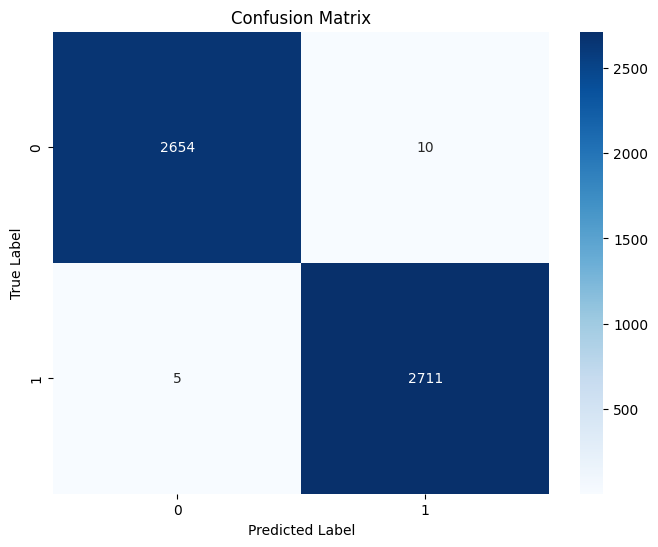

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=label_encoder.transform(label_encoder.classes_))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


ROC AUC Score: 1.0


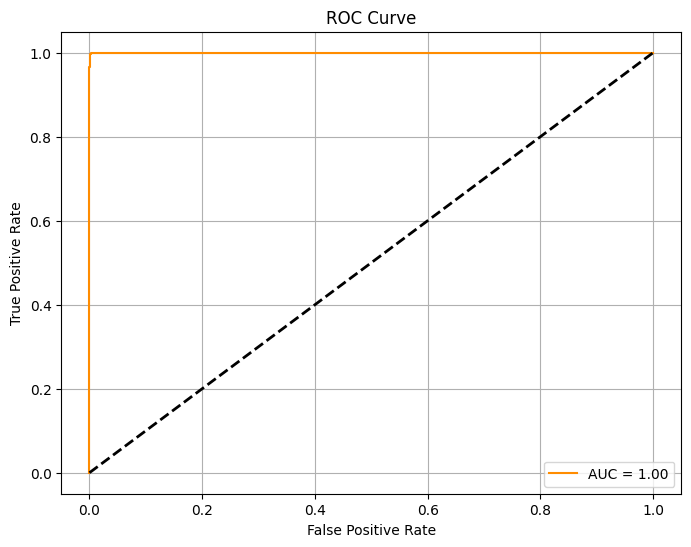

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get probabilities for positive class (usually class 1)
y_scores = model.predict_proba(X_test)[:, 1]

# Compute ROC AUC
auc_score = roc_auc_score(y_test, y_scores)
print("ROC AUC Score:", round(auc_score, 4))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


Average Precision (PR Curve): 1.0


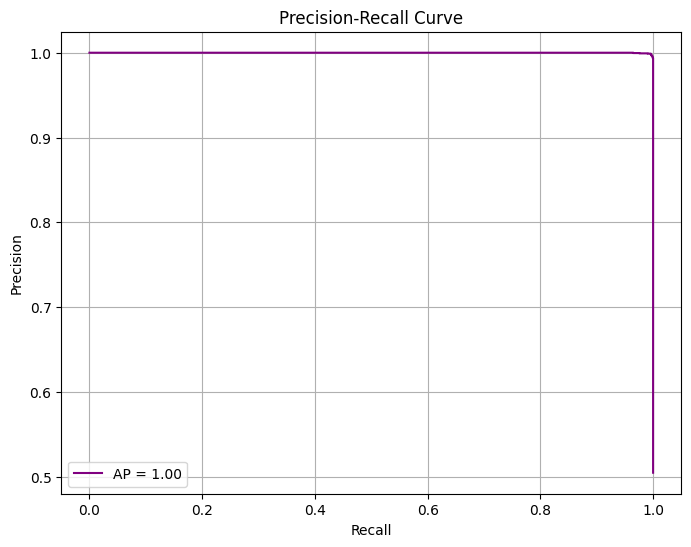

In [45]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Use class 1 probabilities
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

print("Average Precision (PR Curve):", round(avg_precision, 4))

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}", color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


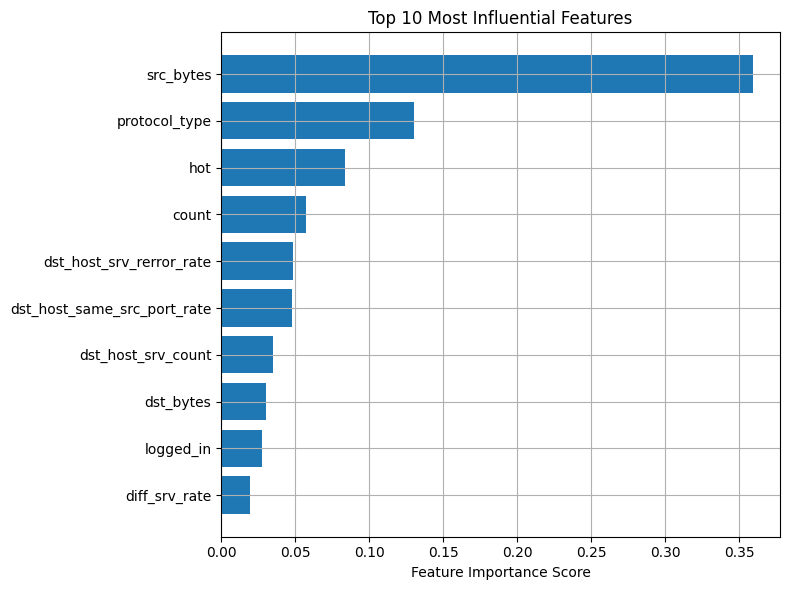

In [43]:
import numpy as np

feature_importances = model.feature_importances_
features = X_train.columns
top_idx = np.argsort(feature_importances)[-10:]  # Top 10

plt.figure(figsize=(8,6))
plt.barh(range(len(top_idx)), feature_importances[top_idx], align="center")
plt.yticks(range(len(top_idx)), [features[i] for i in top_idx])
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Most Influential Features")
plt.grid()
plt.tight_layout()
plt.show()


C:\Users\darsh\AppData\Local\Temp\ipykernel_19788\3755905948.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='pastel')


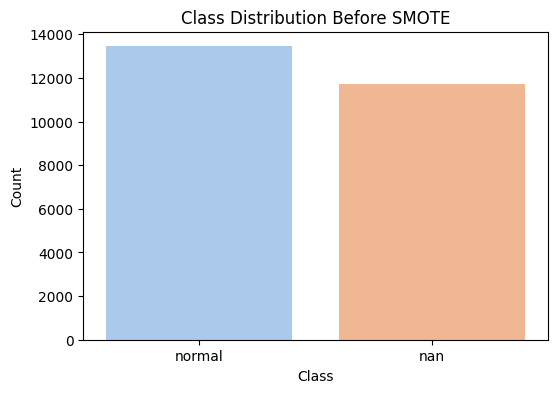

C:\Users\darsh\AppData\Local\Temp\ipykernel_19788\3755905948.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_sm, palette='viridis')


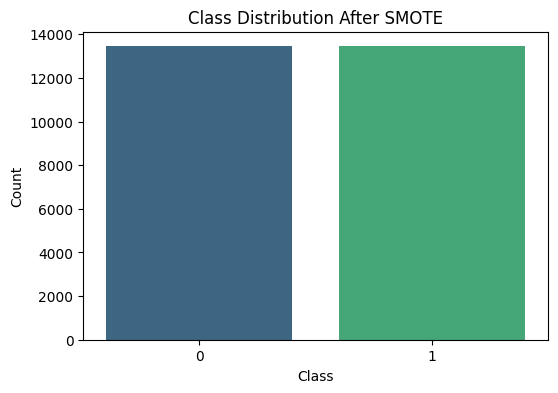

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Before SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_train, palette='pastel')
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# After SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_sm, palette='viridis')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


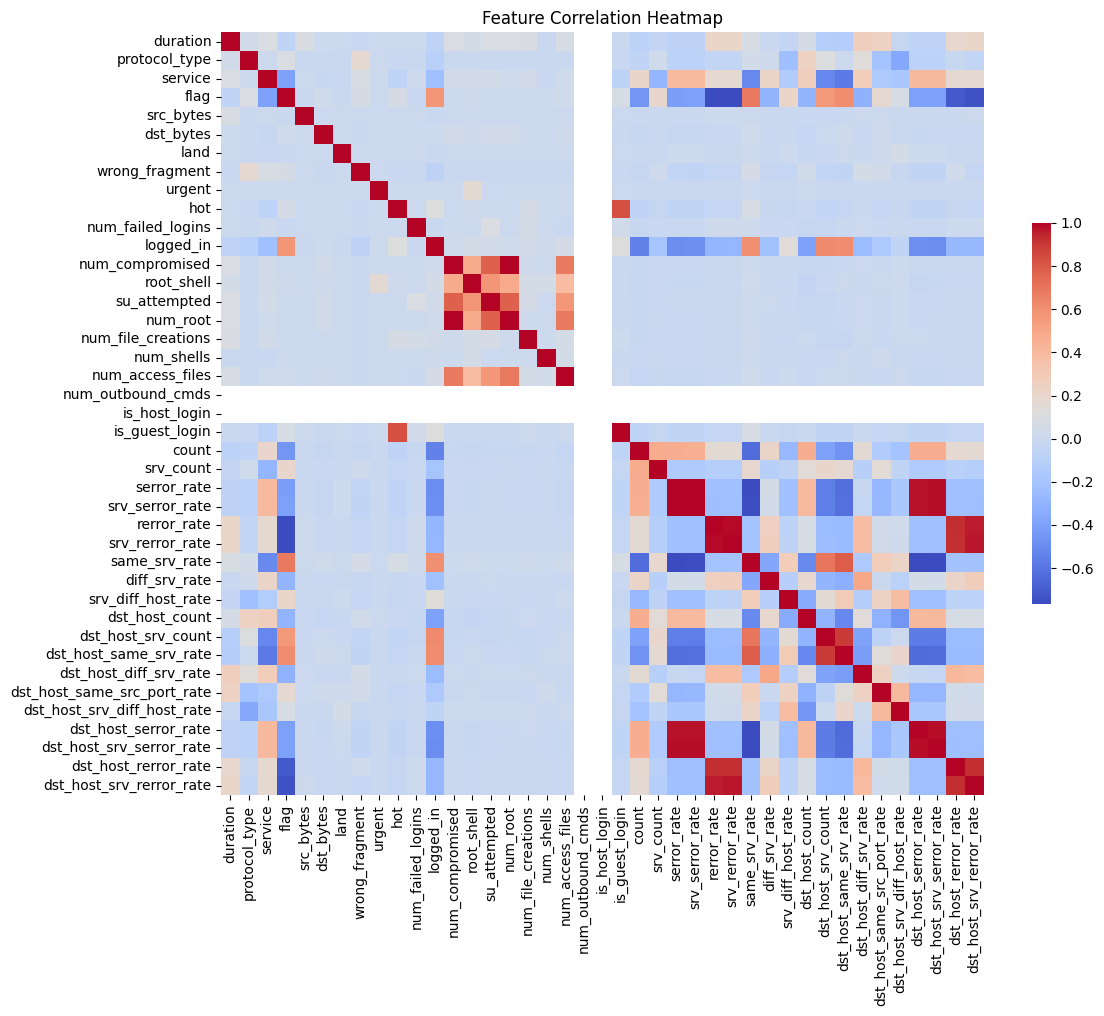

In [47]:
corr = X_train.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', square=True, cbar_kws={'shrink': 0.5})
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


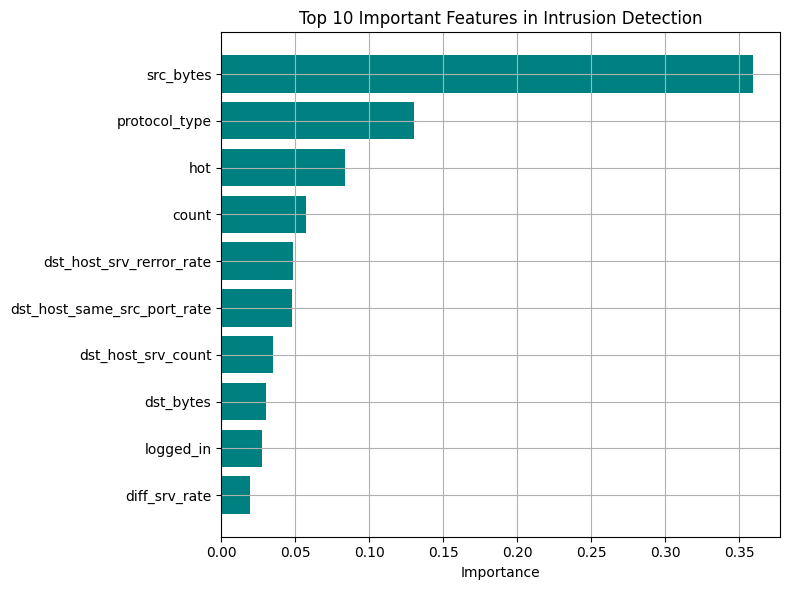

In [48]:
import numpy as np

feature_importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(feature_importances)[-10:]  # Top 10

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), feature_importances[indices], color='teal')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Importance")
plt.title("Top 10 Important Features in Intrusion Detection")
plt.grid()
plt.tight_layout()
plt.show()


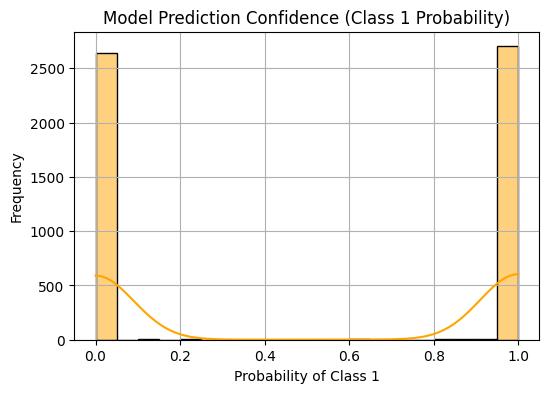

In [49]:
y_scores = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(6,4))
sns.histplot(y_scores, bins=20, kde=True, color='orange')
plt.title("Model Prediction Confidence (Class 1 Probability)")
plt.xlabel("Probability of Class 1")
plt.ylabel("Frequency")
plt.grid()
plt.show()


C:\Users\darsh\AppData\Local\Temp\ipykernel_19788\3038789505.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=predicted_classes, palette='Set2')


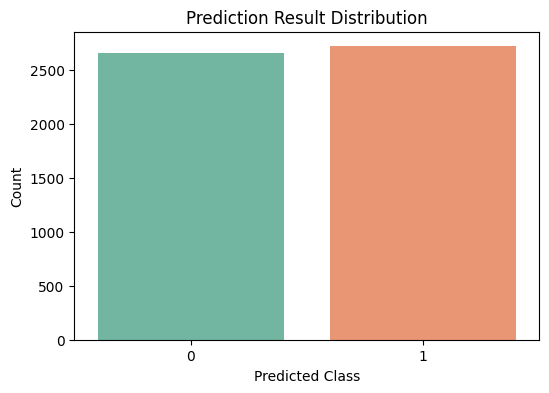

In [50]:
import pandas as pd

predicted_classes = pd.Series(y_pred)
plt.figure(figsize=(6,4))
sns.countplot(x=predicted_classes, palette='Set2')
plt.title("Prediction Result Distribution")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.show()


In [51]:
import pickle

with open("xgb_nids_model.pkl", "wb") as f:
    pickle.dump(model, f)


In [ ]:
!streamlit run app.py
